In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import umap.umap_ as umap

warnings.filterwarnings("ignore")

In [54]:
# Load data
data_df_encoded = pd.read_csv("./data/processed_data.csv")
X = data_df_encoded.drop(columns=["price", "Log Price"])
y = data_df_encoded["Log Price"]

# Train/test split
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [55]:
# Standardize before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
# PCA: keep enough components to explain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA: {X_train_pca.shape[1]} components explain 95% variance.")

PCA: 99 components explain 95% variance.


In [57]:
svd = TruncatedSVD(n_components=30, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)
print(f"TruncatedSVD: {X_train_svd.shape[1]} components used.")

TruncatedSVD: 30 components used.


In [58]:
umap_reducer = umap.UMAP(n_components=20, random_state=42)
X_train_umap = umap_reducer.fit_transform(X_train)
X_test_umap = umap_reducer.transform(X_test)
print(f"UMAP: {X_train_umap.shape[1]} components used.")

UMAP: 20 components used.


ValueError: 'c' argument has 1000 elements, which is inconsistent with 'x' and 'y' with size 1216.

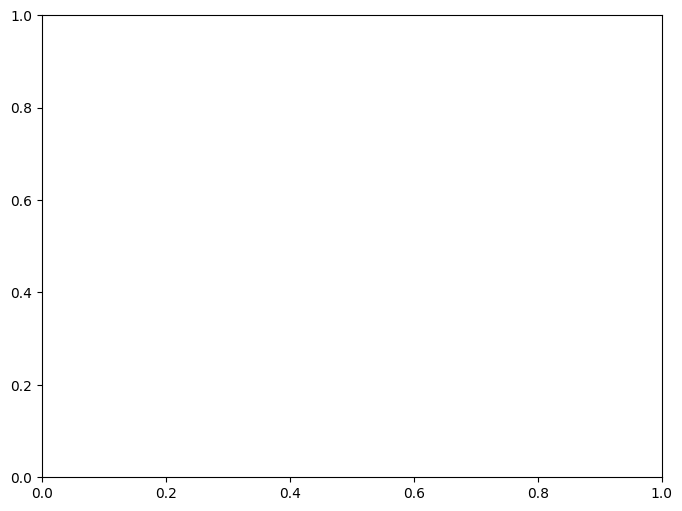

In [59]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_train_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train[:1000], cmap="viridis", alpha=0.7
)
plt.colorbar(label="Log Price")
plt.title("t-SNE Visualization of Feature Space")
plt.show()

In [8]:
# Train Models (Without Hyperparameter Tuning) with Selected Features to get a sense of performance
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=10000),
    "Random Forest": RandomForestRegressor(
        random_state=42, n_estimators=200, max_depth=15
    ),
    "Extra Trees": ExtraTreesRegressor(random_state=42, n_estimators=200, max_depth=15),
    "HistGBM": HistGradientBoostingRegressor(random_state=42, max_iter=200),
    "SVR": SVR(kernel="rbf", C=10, gamma="scale"),
    "CatBoost": CatBoostRegressor(
        verbose=0, random_state=42, learning_rate=0.05, iterations=500, depth=4
    ),
    "XGBoost": XGBRegressor(
        random_state=42, n_estimators=200, max_depth=5, learning_rate=0.05
    ),
    "LightGBM": LGBMRegressor(
        random_state=42, n_estimators=200, max_depth=5, learning_rate=0.05, verbose=-1
    ),
}

In [9]:
def evaluate_models(X_tr, X_te, y_tr, y_te, models, title=""):
    results = {}
    for name, model in models.items():
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        y_pred_train = model.predict(X_tr)
        results[name] = {
            "RMSE Test": np.sqrt(mean_squared_error(y_te, y_pred)),
            "MAE Test": mean_absolute_error(y_te, y_pred),
            "R2 Test": r2_score(y_te, y_pred),
            "RMSE Train": np.sqrt(mean_squared_error(y_tr, y_pred_train)),
            "R2 Train": r2_score(y_tr, y_pred_train),
        }
    results_df = pd.DataFrame(results).T
    print(f"\nResults ({title}):\n", results_df)
    return results_df


# Evaluate on PCA, SVD, UMAP
results_pca = evaluate_models(X_train_pca, X_test_pca, y_train, y_test, models, "PCA")
results_svd = evaluate_models(
    X_train_svd, X_test_svd, y_train, y_test, models, "TruncatedSVD"
)
results_umap = evaluate_models(
    X_train_umap, X_test_umap, y_train, y_test, models, "UMAP"
)


Results (PCA):
                    RMSE Test  MAE Test   R2 Test  RMSE Train  R2 Train
Linear Regression   0.130002  0.100320  0.693867    0.119013  0.774428
Ridge               0.129989  0.100308  0.693929    0.119013  0.774428
Lasso               0.134383  0.101731  0.672883    0.133884  0.714536
Random Forest       0.134361  0.104300  0.672992    0.055197  0.951479
Extra Trees         0.126781  0.098995  0.708850    0.011716  0.997814
HistGBM             0.121717  0.095137  0.731641    0.006736  0.999277
SVR                 0.129250  0.098761  0.697397    0.076704  0.906301
CatBoost            0.119773  0.091752  0.740147    0.061343  0.940073
XGBoost             0.130044  0.099962  0.693668    0.027017  0.988376
LightGBM            0.125370  0.097977  0.715294    0.040377  0.974037

Results (TruncatedSVD):
                    RMSE Test  MAE Test   R2 Test  RMSE Train  R2 Train
Linear Regression   0.107883  0.082500  0.789179    0.114900  0.789752
Ridge               0.107794  0.08

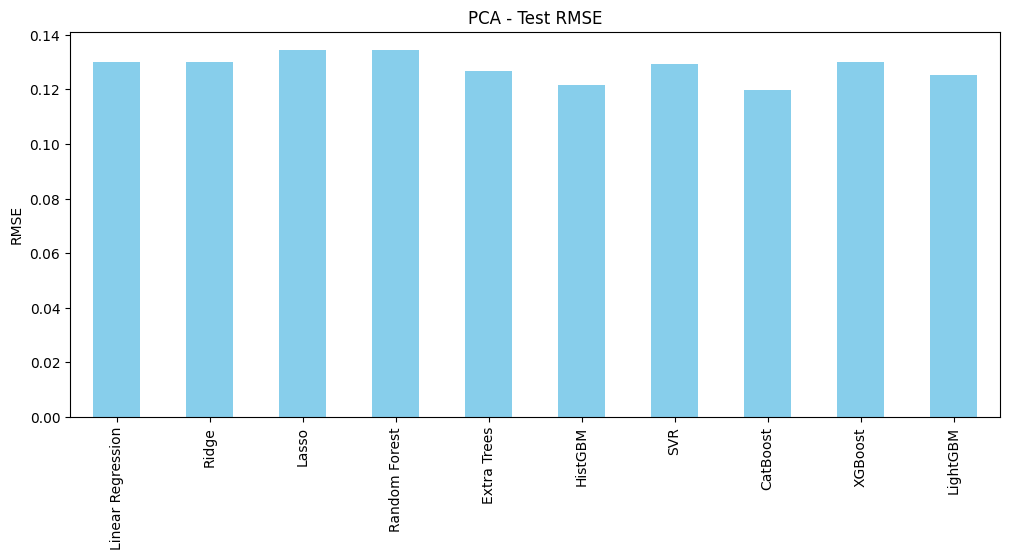

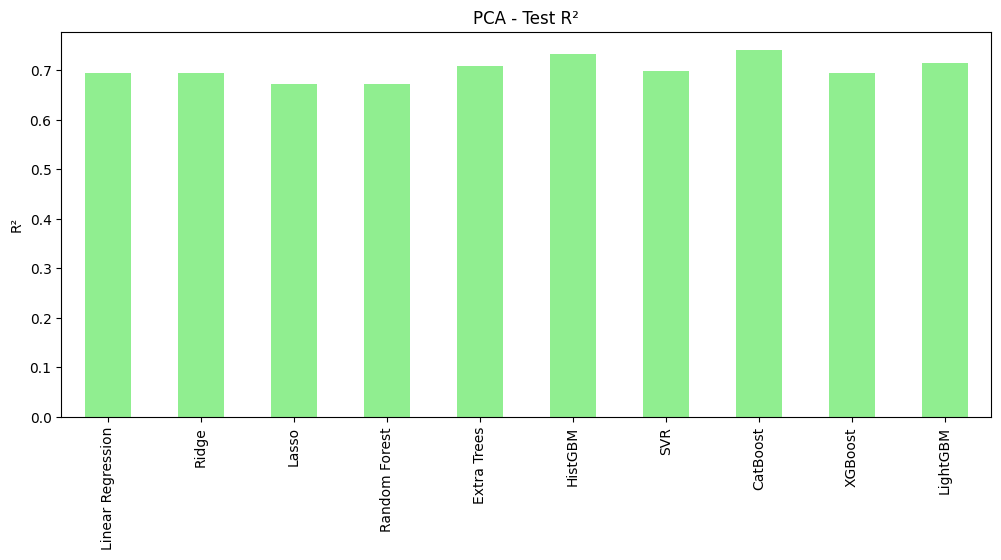

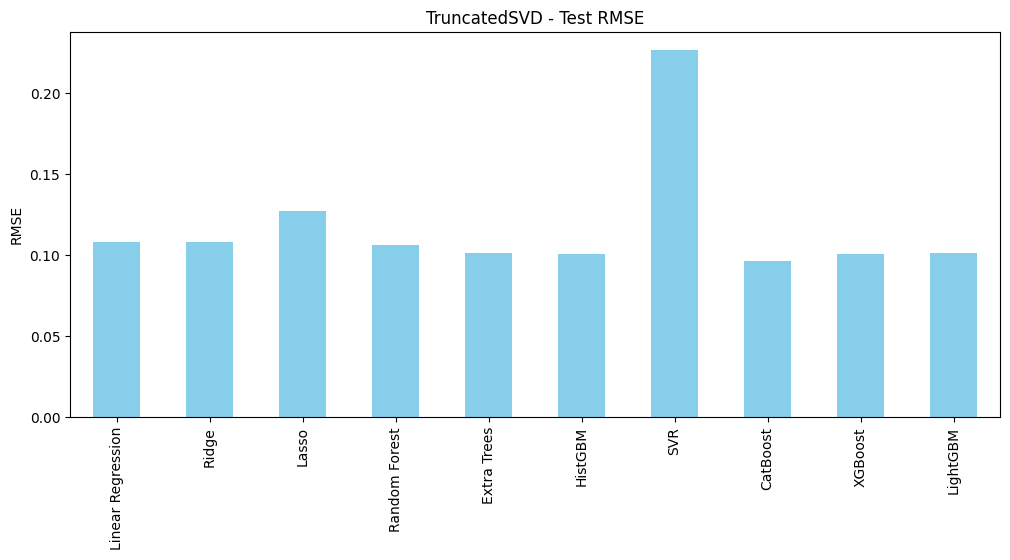

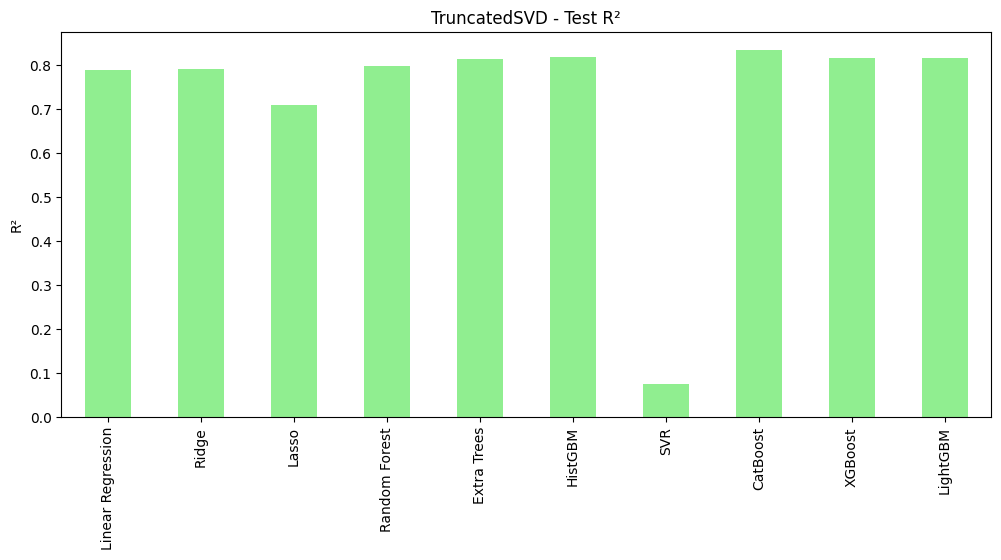

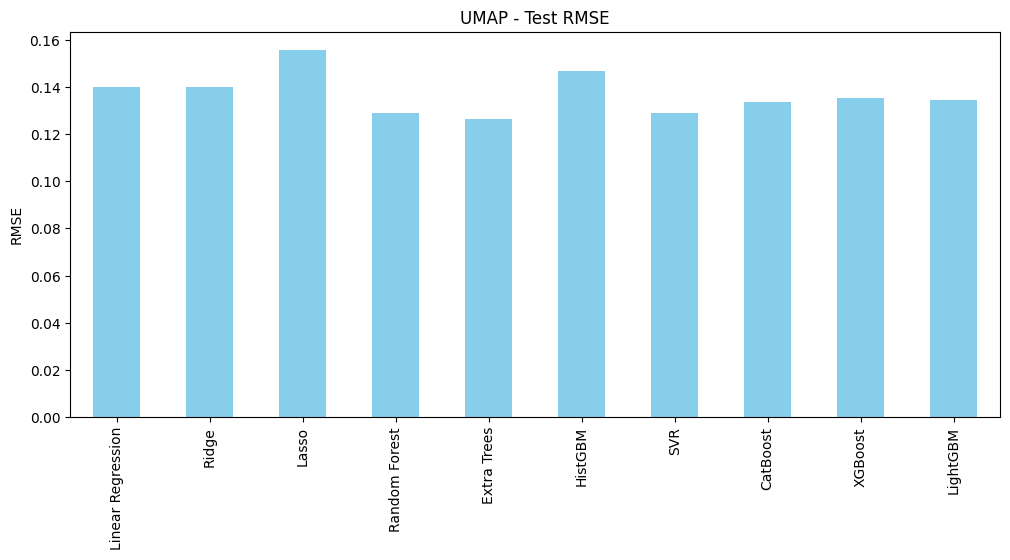

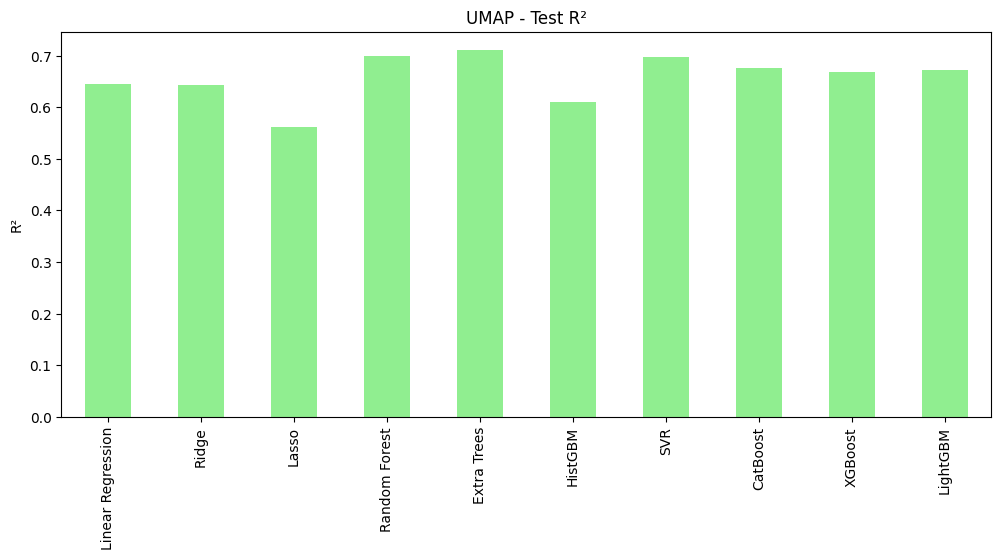

In [10]:
def plot_results(results_df, title):
    plt.figure(figsize=(12, 5))
    results_df["RMSE Test"].plot(kind="bar", color="skyblue")
    plt.title(f"{title} - Test RMSE")
    plt.ylabel("RMSE")
    plt.show()

    plt.figure(figsize=(12, 5))
    results_df["R2 Test"].plot(kind="bar", color="lightgreen")
    plt.title(f"{title} - Test R²")
    plt.ylabel("R²")
    plt.show()


plot_results(results_pca, "PCA")
plot_results(results_svd, "TruncatedSVD")
plot_results(results_umap, "UMAP")

In [11]:
models_and_grids = {
    "Random Forest": (
        RandomForestRegressor(random_state=42),
        {"n_estimators": [100, 200], "max_depth": [10, 20]},
    ),
    "Extra Trees": (
        ExtraTreesRegressor(random_state=42),
        {"n_estimators": [100, 200], "max_depth": [10, 20]},
    ),
    "HistGBM": (
        HistGradientBoostingRegressor(random_state=42),
        {"max_iter": [100, 200], "max_depth": [None, 10]},
    ),
    "SVR": (SVR(), {"C": [1, 10], "gamma": ["scale", "auto"]}),
    "Ridge": (Ridge(), {"alpha": [0.1, 1, 10]}),
    "Lasso": (Lasso(max_iter=10000), {"alpha": [0.01, 0.1, 1]}),
    "CatBoost": (
        CatBoostRegressor(verbose=False, random_state=42),
        {"iterations": [500], "learning_rate": [0.01, 0.05], "depth": [4, 6]},
    ),
    "XGBoost": (
        XGBRegressor(random_state=42),
        {
            "n_estimators": [100, 200],
            "max_depth": [3, 5],
            "learning_rate": [0.01, 0.05],
        },
    ),
    "LightGBM": (
        LGBMRegressor(verbose=-1, random_state=42),
        {
            "n_estimators": [100, 200],
            "max_depth": [3, 5],
            "learning_rate": [0.01, 0.05],
        },
    ),
}

In [12]:
reduced_sets = {
    "PCA": (X_train_pca, X_test_pca),
    "SVD": (X_train_svd, X_test_svd),
    "UMAP": (X_train_umap, X_test_umap),
}

In [13]:
all_results = {}

for red_name, (Xtr, Xte) in reduced_sets.items():
    print(f"\n--- {red_name} ---")
    results = {}
    for model_name, (model, param_grid) in models_and_grids.items():
        print(f"Tuning {model_name}...")
        grid = GridSearchCV(
            model, param_grid, scoring="neg_root_mean_squared_error", cv=3, n_jobs=-1
        )
        grid.fit(Xtr, y_train)
        best = grid.best_estimator_
        y_pred = best.predict(Xte)
        y_pred_train = best.predict(Xtr)
        results[model_name] = {
            "Best Params": grid.best_params_,
            "RMSE Test": np.sqrt(mean_squared_error(y_test, y_pred)),
            "MAE Test": mean_absolute_error(y_test, y_pred),
            "R2 Test": r2_score(y_test, y_pred),
            "RMSE Train": np.sqrt(mean_squared_error(y_train, y_pred_train)),
            "R2 Train": r2_score(y_train, y_pred_train),
        }
    results_df = pd.DataFrame(results).T
    results_df["Reduction Method"] = red_name
    results_df["Model"] = results_df.index
    print(results_df[["RMSE Test", "MAE Test", "R2 Test", "Best Params"]])
    all_results[red_name] = results_df


--- PCA ---
Tuning Random Forest...
Tuning Extra Trees...
Tuning HistGBM...
Tuning SVR...
Tuning Ridge...
Tuning Lasso...
Tuning CatBoost...


/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered

Tuning XGBoost...
Tuning LightGBM...


/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  war

              RMSE Test  MAE Test   R2 Test  \
Random Forest  0.134932  0.104682  0.670208   
Extra Trees    0.127313   0.09913  0.706399   
HistGBM        0.122071  0.094687   0.73008   
SVR            0.126835  0.096748  0.708601   
Ridge          0.129875  0.100202  0.694464   
Lasso          0.134383  0.101731  0.672883   
CatBoost       0.119773  0.091752  0.740147   
XGBoost        0.126928  0.097685   0.70817   
LightGBM        0.12537  0.097977  0.715294   

                                                     Best Params  
Random Forest             {'max_depth': 20, 'n_estimators': 200}  
Extra Trees               {'max_depth': 20, 'n_estimators': 200}  
HistGBM                       {'max_depth': 10, 'max_iter': 200}  
SVR                                   {'C': 1, 'gamma': 'scale'}  
Ridge                                              {'alpha': 10}  
Lasso                                            {'alpha': 0.01}  
CatBoost       {'depth': 4, 'iterations': 500, 'learning_rat

/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/n

Tuning XGBoost...
Tuning LightGBM...


/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  war

              RMSE Test  MAE Test   R2 Test  \
Random Forest  0.105482   0.08161  0.798456   
Extra Trees    0.100021   0.07819  0.818785   
HistGBM        0.101338  0.075411  0.813981   
SVR            0.091655  0.068284   0.84783   
Ridge          0.107794  0.082402  0.789525   
Lasso          0.126725  0.099417  0.709104   
CatBoost       0.095381  0.071166  0.835208   
XGBoost        0.101092    0.0787  0.814882   
LightGBM        0.10124  0.077129  0.814342   

                                                     Best Params  
Random Forest             {'max_depth': 20, 'n_estimators': 200}  
Extra Trees               {'max_depth': 20, 'n_estimators': 200}  
HistGBM                       {'max_depth': 10, 'max_iter': 200}  
SVR                                    {'C': 1, 'gamma': 'auto'}  
Ridge                                               {'alpha': 1}  
Lasso                                            {'alpha': 0.01}  
CatBoost       {'depth': 6, 'iterations': 500, 'learning_rat

/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered

Tuning XGBoost...
Tuning LightGBM...


/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/narcisfanica/Documents/School/Deprecated/EDA/eda_car_listings/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  war

              RMSE Test  MAE Test   R2 Test  \
Random Forest  0.128689   0.10198   0.70002   
Extra Trees    0.126132  0.098809  0.711822   
HistGBM        0.140107  0.110479  0.644423   
SVR            0.125463  0.098553  0.714868   
Ridge          0.139633  0.109299  0.646826   
Lasso          0.155687  0.121021  0.560948   
CatBoost       0.131643  0.102468  0.686089   
XGBoost        0.134887  0.106042  0.670427   
LightGBM       0.132835  0.104603  0.680378   

                                                     Best Params  
Random Forest             {'max_depth': 10, 'n_estimators': 200}  
Extra Trees               {'max_depth': 10, 'n_estimators': 200}  
HistGBM                       {'max_depth': 10, 'max_iter': 100}  
SVR                                   {'C': 10, 'gamma': 'auto'}  
Ridge                                             {'alpha': 0.1}  
Lasso                                            {'alpha': 0.01}  
CatBoost       {'depth': 6, 'iterations': 500, 'learning_rat

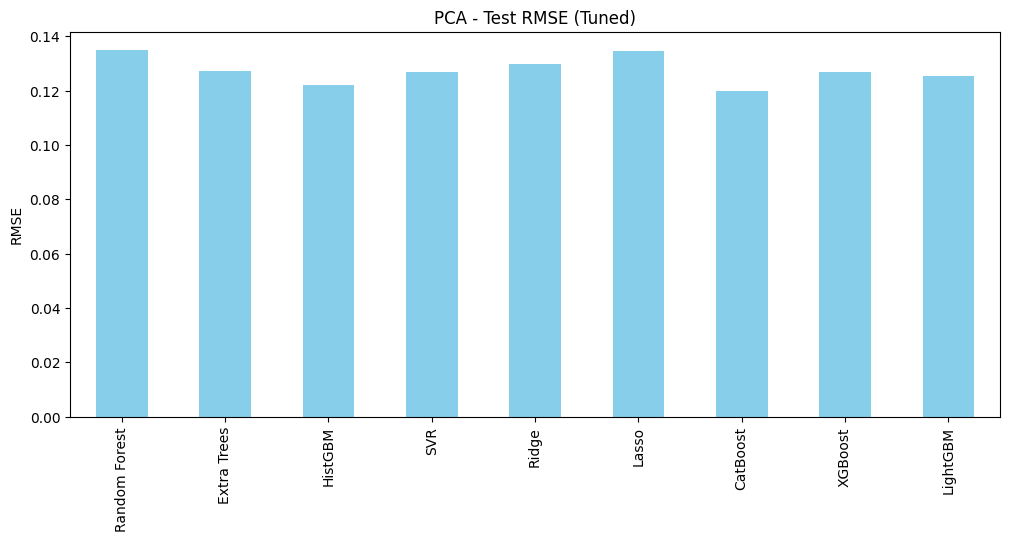

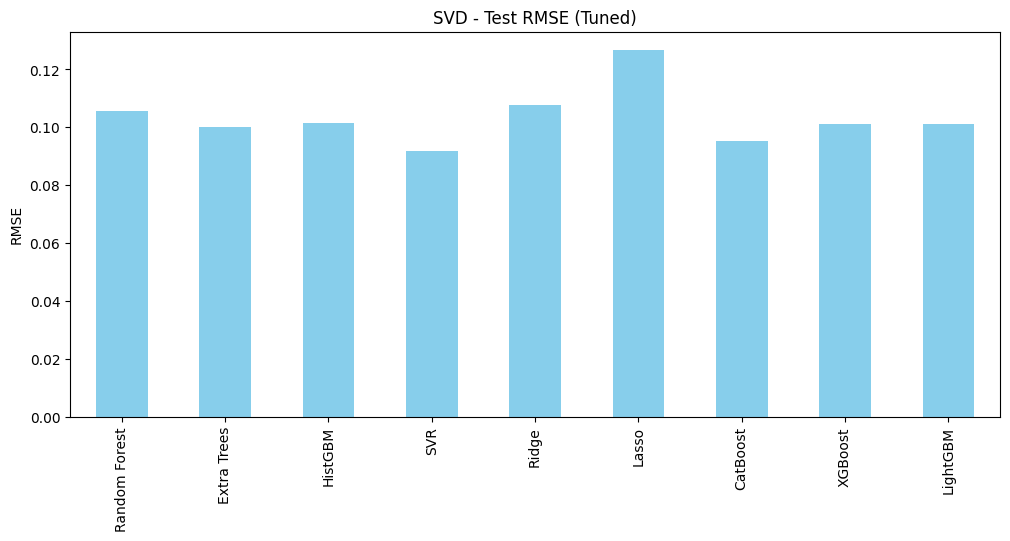

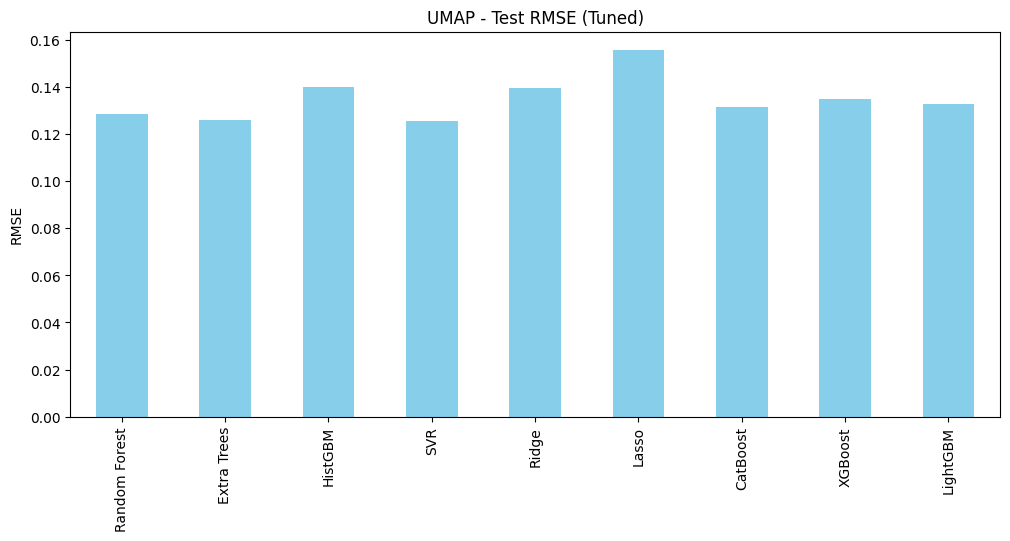

In [14]:
# Example: Plot RMSE for each reduction
for red_name, results_df in all_results.items():
    plt.figure(figsize=(12, 5))
    results_df["RMSE Test"].plot(kind="bar", color="skyblue")
    plt.title(f"{red_name} - Test RMSE (Tuned)")
    plt.ylabel("RMSE")
    plt.show()

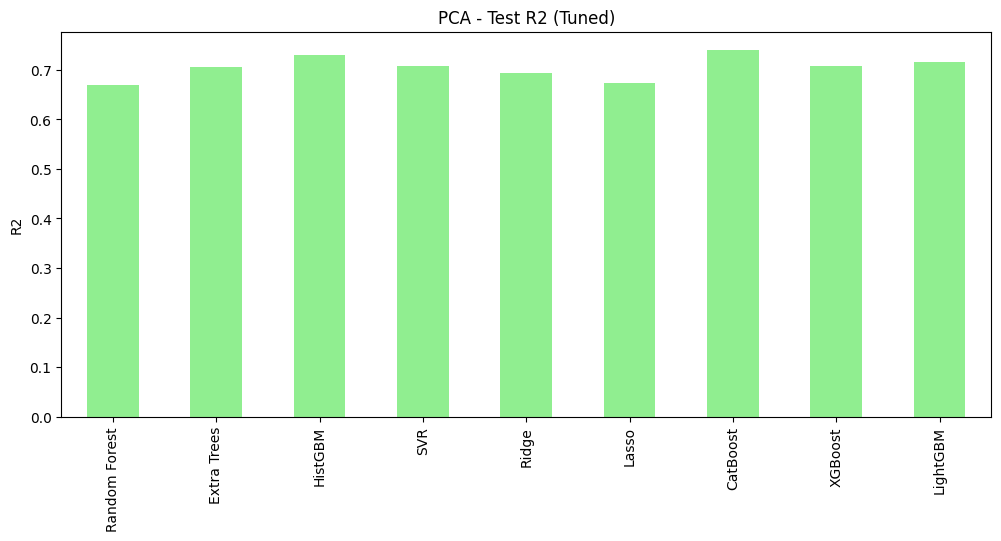

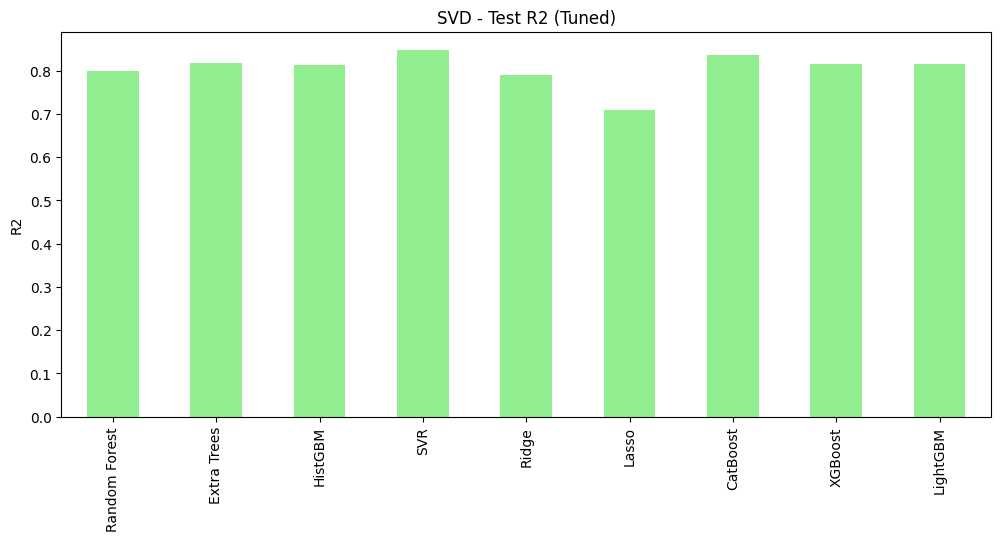

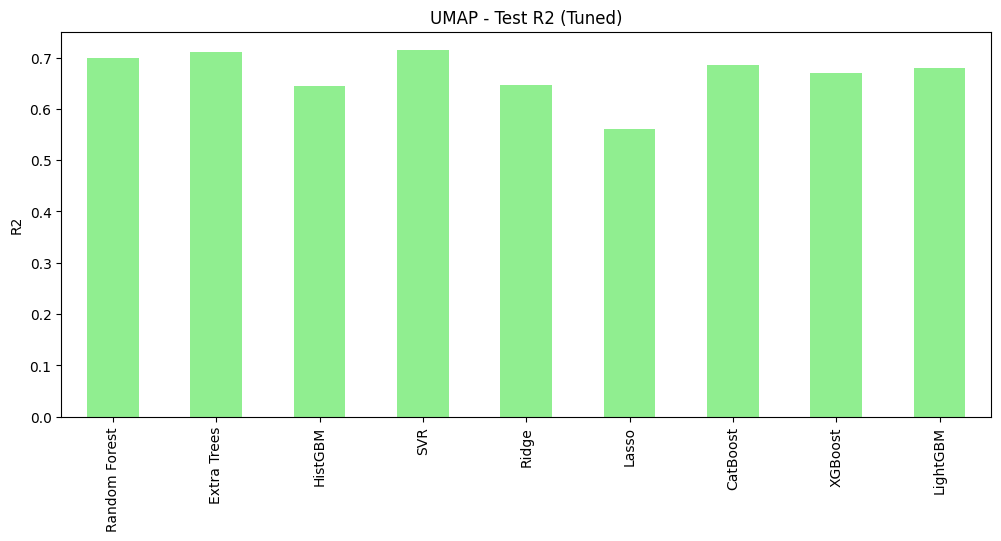

In [ ]:
# Example: Plot RMSE for each reduction
for red_name, results_df in all_results.items():
    plt.figure(figsize=(12, 5))
    results_df["R2 Test"].plot(kind="bar", color="lightgreen")
    plt.title(f"{red_name} - Test R2 (Tuned)")
    plt.ylabel("R2")
    plt.show()

In [16]:
all_results_df = pd.concat(all_results.values())
all_results_df.to_csv("./data/all_results_df.csv", index=False)